<a href="https://colab.research.google.com/github/Krankile/ensemble-forcasting/blob/main/LSTM_feature_extractor_v04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install wandb --upgrade

In [34]:
import copy
import random
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from more_itertools import chunked

from tqdm import tqdm

import torch
from torch import nn

plt.rcParams["figure.figsize"] = (12,4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
!nvidia-smi

Fri Oct 22 14:38:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWicQ1o1RYtOwRhw5XaNwk2M7cZEz2H6hSsgsPuwG7IXfxpSmHKkY0Q
Mounted at /content/drive


In [5]:
DRIVE_PATH = "/content/drive/MyDrive/10 – NTNU/# 9. Semester/Prosjektoppgave_runs"

In [6]:
import wandb

wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [28]:
config = dict(
    epochs=100,
    n_series=2000,
    embedding_dim=128,
    hidden_dim=256,
    learning_rate=1e-3,
    dataset="droso-sine-v03",
    dataclass="droso-sine",
    architecture="LSTM",
    batch_size=50,
    optimizer="adamw",
)

In [26]:
optimizers = {
    "adam": torch.optim.Adam,
    "sgd": torch.optim.SGD,
    "adamw": torch.optim.AdamW,
}

In [10]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim, hidden_dim):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim = embedding_dim
    self.hidden_dim = hidden_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((-1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((-1, self.n_features, self.embedding_dim))

In [11]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim, hidden_dim, n_features):
    super(Decoder, self).__init__()

    self.seq_len = seq_len
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.n_features = n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(1, self.seq_len, 1)
    #x = x.reshape((-1, self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((-1, self.seq_len, self.hidden_dim))

    return self.output_layer(x)

In [12]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim, hidden_dim):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim, hidden_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, hidden_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [13]:
def train_model(model, train_dataset, val_dataset, conf):
    starttime = datetime.now()
    logpath = f"{DRIVE_PATH}-logs-{starttime}"

    with open(logpath, mode="w") as f:
        f.write("Epoch;Train_loss;Val_loss\n")

    optimizer = optimizers[conf.optimizer](model.parameters(), lr=conf.learning_rate)
    # Test with sMAPE and MASE as well maybe

    criterion = nn.L1Loss(reduction='sum').to(device)
    wandb.watch(model, criterion, log="all", log_freq=1)

    history = dict(train=[], val=[])

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0

    it = tqdm(range(1, conf.epochs + 1))

    b_size = conf.batch_size

    for epoch in it:
        model = model.train()

        train_losses = []
        for i in range(0, len(train_dataset), b_size):
            optimizer.zero_grad()
            seq_true = train_dataset[i:i+b_size]
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)

            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for i in range(0, len(val_dataset), b_size):
                seq_true = val_dataset[i:i+b_size]
                seq_true = seq_true.to(device)
                seq_pred = model(seq_true)

                loss = criterion(seq_pred, seq_true)
                val_losses.append(loss.item())

        train_loss = np.mean(train_losses) / b_size
        val_loss = np.mean(val_losses) / b_size

        with open(logpath, mode="a") as f:
            f.write(f"{epoch};{train_loss};{val_loss}\n")

        wandb.log({"train_loss": train_loss, "val_loss": val_loss}, step=epoch)

        history['train'].append(train_loss)
        history['val'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

            with open(DRIVE_PATH + "model_weights", "wb") as f:
                torch.save(best_model_wts, f)

            torch.save(best_model_wts, "model.torch")
            wandb.save("model.torch")

        it.set_postfix(
            train_loss=train_loss,
            val_loss=val_loss
        )

    model.load_state_dict(best_model_wts)
    return model.eval(), history

In [24]:
def prepare(data):
    val_dataset = random.sample(data, k=int(0.1 * len(data)))

    train_tensor = torch.Tensor(data).reshape((-1, 100, 1))
    val_tensor = torch.Tensor(val_dataset).reshape((-1, 100, 1))

    _, seq_len, n_features = train_tensor.shape

    return train_tensor, val_tensor, seq_len, n_features

def get_data_droso_3class_v01(n_series):
    train_dataset = []

    xs = np.linspace(-1, 1, int(n_series / 3))

    for i in xs:
        train_dataset.append(np.linspace(i, i, 100))
        train_dataset.append(np.linspace(-i, i, 100))
        train_dataset.append(-i*np.sin(np.linspace(-i*4*np.pi, i*4*np.pi, 100)))

    return prepare(train_dataset)


def get_data_droso_sine_v01(n_series):
    train_dataset = []

    for _ in range(n_series):
        train_dataset.append(np.sin(np.linspace(-4*np.pi, 4*np.pi, 100)))

    return prepare(train_dataset)

def get_data_droso_sine_v02(n_series):
    train_dataset = []

    for _ in range(n_series // 2):
        train_dataset.append(-0.5 + np.sin(np.linspace(-4*np.pi, 4*np.pi, 100)))
        train_dataset.append(0.5 + np.sin(np.linspace(-4*np.pi, 4*np.pi, 100)))

    return prepare(train_dataset)

def get_data_droso_sine_v03(n_series):
    train_dataset = []

    for _ in range(n_series // 2):
        train_dataset.append(-0.5 + np.sin(np.linspace(-4*np.pi, 4*np.pi, 100)))
        train_dataset.append(0.5 + np.sin(np.linspace(-4*np.pi, 4*np.pi, 100)))

    return prepare(train_dataset)

get_data = {
    "droso-3class-v01": get_data_droso_3class_v01,
    "droso-sine-v01": get_data_droso_sine_v01,
    "droso-sine-v02": get_data_droso_sine_v02,
}

## Run training

In [27]:
with wandb.init(project="lstm-vae", config=config, entity="krankile"):
    conf = wandb.config

    train_tensor, val_tensor, seq_len, n_features = get_data[conf.dataset](conf.n_series)

    model = RecurrentAutoencoder(
        seq_len=seq_len,
        n_features=n_features,
        embedding_dim=conf.embedding_dim,
        hidden_dim=conf.hidden_dim,
    )

    model = model.to(device)

    model, history = train_model(
        model,
        train_tensor,
        val_tensor,
        conf=conf,
    )

100%|██████████| 100/100 [05:57<00:00,  3.58s/it, train_loss=2.34, val_loss=3.26]


train_loss,██▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁
train_loss,2.34269
val_loss,3.2594


## Check results

In [29]:
train_tensor, val_tensor, seq_len, n_features = get_data[conf.dataset](conf.n_series)

model = RecurrentAutoencoder(
    seq_len=seq_len,
    n_features=n_features,
    embedding_dim=conf.embedding_dim,
    hidden_dim=conf.hidden_dim,
)
model.load_state_dict(torch.load("/content/model.torch"))

model = model.eval().cpu()

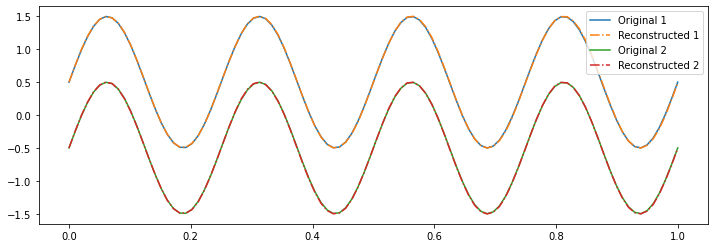

In [38]:
series = 2

for i in range(1, series+1):
    plt.plot(np.linspace(0, 1, 100), train_tensor[i], label=f"Original {i}");
    plt.plot(
        np.linspace(0, 1, 100),
        model(train_tensor[i]).reshape((-1)).detach().numpy(),
        label=f"Reconstructed {i}",
        linestyle="-."
    )
plt.legend();

# Archive

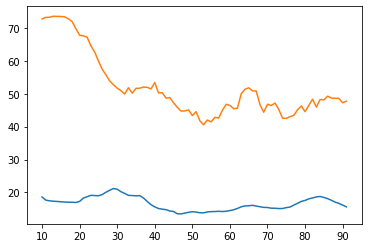

In [ ]:
# Plot training data
logspath = "/content/drive/MyDrive/# 9. Semester/Prosjektoppgave_runs-logs-2021-10-20 15:58:18.177512"

logs = pd.read_csv(logspath, sep=";").set_index("Epoch")
logs["tloss_smooth"] = logs["Train_loss"].rolling(10).mean()
logs["vloss_smooth"] = logs["Val_loss"].rolling(10).mean()
plt.plot(logs["tloss_smooth"]);
plt.plot(logs["vloss_smooth"]);